### Import Libraries

In [45]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers


### Set Parameters

In [46]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-3
TRAIN_DIR = '../dataset/train'
VAL_DIR = '../dataset/validation'
NUM_CLASSES = 8

### Augmentation

In [47]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [48]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 800 images belonging to 8 classes.
Found 160 images belonging to 8 classes.


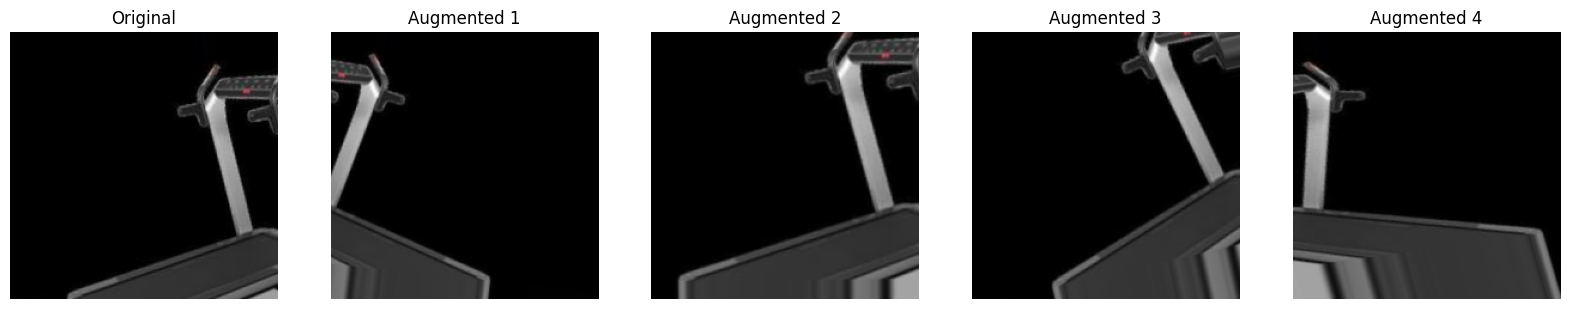

In [ ]:
def visualize_original_and_augmented_images():
    original_images, labels = next(train_generator)

    # Ambil gambar pertama dari batch asli tanpa augmentasi
    original_image = original_images[0]

    # Buat list untuk menyimpan gambar yang sudah di-augmentasi
    images = [original_image]  # Menyimpan gambar asli pertama

    # Augmentasi gambar pertama beberapa kali
    for _ in range(4):
        image_aug = train_datagen.random_transform(original_image)  # Terapkan augmentasi pada gambar asli
        images.append(tf.keras.utils.array_to_img(image_aug))

    # Plot gambar asli dan gambar yang sudah di-augmentasi
    fig, axs = plt.subplots(1, 5, figsize=(20, 7))  # 1 baris, 5 kolom
    titles = ['Original', 'Augmented 1', 'Augmented 2', 'Augmented 3', 'Augmented 4']

    for ax, image, title in zip(axs, images, titles):
        if title == 'Original':  # Tampilkan gambar asli
            ax.imshow(tf.keras.utils.array_to_img(image))
        else:
            ax.imshow(image)
        ax.set_title(title)
        ax.axis('off')

    plt.show()


### Optimization

In [50]:
AUTOTUNE = tf.data.AUTOTUNE

def generator_to_dataset(generator):
    dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_signature=(
            tf.TensorSpec(shape=(None, IMG_HEIGHT, IMG_WIDTH, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 15), dtype=tf.float32)
        )
    )
    return dataset

In [51]:
train_dataset = generator_to_dataset(train_generator)
val_dataset = generator_to_dataset(val_generator)

In [52]:
# Apply prefetch and optimize the data pipeline
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

### Load Pre-trained MobileNetV2

In [53]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False  # Freeze the base model initially

### Modeling

In [54]:
# Build the model
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01)), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [55]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [56]:
# Train the model (initially without fine-tuning)
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)

Epoch 1/20
25/25 [==============================] - 13s 384ms/step - loss: 12.2647 - accuracy: 0.5487 - val_loss: 11.7729 - val_accuracy: 0.5000
Epoch 2/20
25/25 [==============================] - 9s 342ms/step - loss: 9.7952 - accuracy: 0.7600 - val_loss: 9.4043 - val_accuracy: 0.7000
Epoch 3/20
25/25 [==============================] - 8s 337ms/step - loss: 8.1430 - accuracy: 0.7975 - val_loss: 8.2053 - val_accuracy: 0.6375
Epoch 4/20
25/25 [==============================] - 8s 326ms/step - loss: 6.9129 - accuracy: 0.7950 - val_loss: 6.7663 - val_accuracy: 0.6750
Epoch 5/20
25/25 [==============================] - 9s 344ms/step - loss: 5.8515 - accuracy: 0.8350 - val_loss: 6.1915 - val_accuracy: 0.6187
Epoch 6/20
25/25 [==============================] - 9s 353ms/step - loss: 4.9455 - accuracy: 0.8500 - val_loss: 5.5110 - val_accuracy: 0.6125
Epoch 7/20
25/25 [==============================] - 8s 300ms/step - loss: 4.2762 - accuracy: 0.8500 - val_loss: 4.6342 - val_accuracy: 0.6562
Epo

### Fine-Tuning

In [57]:
base_model.trainable = True

# Unfreeze all layers from the last 30 layers of MobileNetV2
for layer in base_model.layers[:-30]:
    layer.trainable = False

In [58]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE / 10),  # Reduce learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [59]:
history_finetune = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)

Epoch 1/20
25/25 [==============================] - 12s 332ms/step - loss: 1.6463 - accuracy: 0.7688 - val_loss: 2.1252 - val_accuracy: 0.6750
Epoch 2/20
25/25 [==============================] - 8s 307ms/step - loss: 1.3002 - accuracy: 0.8763 - val_loss: 2.1173 - val_accuracy: 0.6875
Epoch 3/20
25/25 [==============================] - 7s 281ms/step - loss: 1.0624 - accuracy: 0.9137 - val_loss: 2.0324 - val_accuracy: 0.7000
Epoch 4/20
25/25 [==============================] - 7s 278ms/step - loss: 1.0713 - accuracy: 0.9075 - val_loss: 2.3049 - val_accuracy: 0.7000
Epoch 5/20
25/25 [==============================] - 7s 278ms/step - loss: 0.9919 - accuracy: 0.9350 - val_loss: 2.1790 - val_accuracy: 0.7188
Epoch 6/20
25/25 [==============================] - 7s 277ms/step - loss: 0.9478 - accuracy: 0.9287 - val_loss: 2.0596 - val_accuracy: 0.7063
Epoch 7/20
25/25 [==============================] - 7s 281ms/step - loss: 0.8754 - accuracy: 0.9438 - val_loss: 2.2459 - val_accuracy: 0.6938
Epoch

### Plot Train & Val Acc/Loss

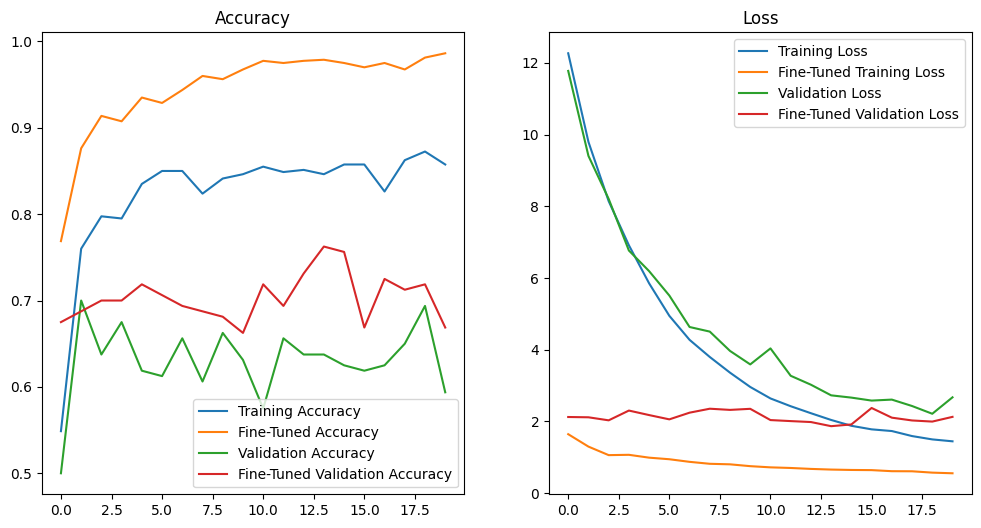

In [60]:
def plot_history(history, history_finetune):
    # Plot the accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history_finetune.history['accuracy'], label='Fine-Tuned Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history_finetune.history['val_accuracy'], label='Fine-Tuned Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()

    # Plot the loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history_finetune.history['loss'], label='Fine-Tuned Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.plot(history_finetune.history['val_loss'], label='Fine-Tuned Validation Loss')
    plt.title('Loss')
    plt.legend()

    plt.show()

plot_history(history, history_finetune)
